# Predicting Diesaster Tweets ******
Flatiron School Data Science: Project 4

Advanced Machine Learning Topics **********
- **Author**: Zaid Shoorbajee
- **Instructor**: Morgan Jones
- **Pace**: Flex, 40 weeks

## Overview and Business Understanding
Lorem ipsum
## Data Undersanding
Lorem ipsum
### Dataset and features
Lorem ipsum
### Target variable
Lorem ipsum
### Scoring
Lorem ipsum

In [1]:
import time
start_time = time.time()

In [2]:
import numpy as np
import pandas as pd

from nltk import FreqDist
from nltk.tokenize import \
    regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from keras import models
from keras import layers
from keras import regularizers
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import LeakyReLU

import re
from collections import OrderedDict, defaultdict, Counter
import itertools
import string

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

pd.options.display.max_colwidth = 150
seed = 7

In [3]:
# Need to revise headers


## Data Preparation

In [4]:
# Loading and previewing the dataset

df = pd.read_csv('./data/disaster_tweets/train.csv')
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

### Keyword and location columns

The `location` column doesn't have much usable information in some cases it's just nonsense:

In [7]:
print('Sample of some of the location values')
df['location'].unique()[7:17].tolist()

Sample of some of the location values


['World Wide!!',
 'Paranaque City',
 'Live On Webcam',
 'milky way',
 'GREENSBORO,NORTH CAROLINA',
 'England.',
 'Sheffield Township, Ohio',
 'India',
 'Barbados',
 'Anaheim']

Therefore I can't use the `location` column without some pre-processing. I will fill the missing values with `location_missing` for now. Later, when I'm processing more of the text data, I'll extract some information from this column.

In [8]:
df['location'] = df['location'].fillna('location_missing')

The `keyword` column shows what was used to search for relevant tweets. This column can give use insight as to what kinds of tweets the keywords yield. 

In [9]:
df['keyword'].value_counts(dropna=False)
# Counter(df['keyword'])[np.NaN]

NaN                      61
fatalities               45
armageddon               42
deluge                   42
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

`keyword` has 61 missing values

In [10]:
# Filling missing values with 'missing_keyword' so I can visualize.

df['keyword'] = df['keyword'].fillna('keyword_missing')

In [11]:
df['keyword'] = df['keyword'].apply(lambda x: x.replace('%20', ' '))

In [12]:
# df['keyword_count_0'] = \
#     df['keyword'].apply(
#         lambda x: Counter(df['keyword'][df['target'] == 0])[x]
#         )
# df['keyword_count_1'] = \
#     df['keyword'].apply(
#         lambda x: Counter(df['keyword'][df['target'] == 1])[x]
#         )

In [13]:
# fig, axes = plt.subplots(ncols=2, figsize=(15, 50))

# sns.countplot(
#     y=df[df['target']==0].sort_values(
#         by='keyword_count_0', ascending=False
#         )['keyword'],
#     color='blue',
#     ax=axes[0]
#     )
# sns.countplot(
#     y=df[df['target']==1].sort_values(
#         by='keyword_count_1', ascending=False
#         )['keyword'],
#     color='red',
#     ax=axes[1]
#     )

# axes[0].set_title('Non-disaster tweets')
# axes[1].set_title('Disaster tweets')

# plt.tight_layout()
# plt.show()

### Tweets and Target
The main feature is `text`, which is the full text of the given tweet. Each tweet is labeled in `target` as referring to a disaster (1) or not (0).
#### Duplicate tweets
Before proceeding, I'll check if there are any tweets that are duplicated.

In [14]:
df['text'].duplicated().sum()

110

There are numerous duplicate tweets, perhaps tweeted by different accounts. The most concerning part of this is that some of these duplicates have contradicting labels. Here are a few examples:

In [15]:
df[df['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam"]

,id,keyword,location,text,target
3240,4656,engulfed,location_missing,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,0
3243,4659,engulfed,Kuwait,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,1
3248,4669,engulfed,Bahrain,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,1
3251,4672,engulfed,location_missing,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,0
3261,4684,engulfed,location_missing,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,0
3266,4691,engulfed,location_missing,He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,0


In [16]:
df[df['text'] == ".POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4"]

,id,keyword,location,text,target
2830,4068,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1
2831,4072,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1
2832,4076,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,0
2833,4077,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1


In [17]:
df[df['text'] == "Caution: breathing may be hazardous to your health."]

,id,keyword,location,text,target
4232,6012,hazardous,location_missing,Caution: breathing may be hazardous to your health.,1
4235,6017,hazardous,location_missing,Caution: breathing may be hazardous to your health.,0


In [18]:
df[df['text'] == "like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit"]

,id,keyword,location,text,target
1221,1760,buildings burning,dallas,like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,1
1349,1950,burning buildings,dallas,like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,0


It seems that some of these tweets were labeled sloppily or are difficult to interpret. In any case, having identical tweets labeled differently will cause unwanted noise in the model. Therefore, I'll drop all duplicated tweets, which account for less than 2% of the dataset.

In [19]:
# Proportion of duplicate tweets

df['text'].duplicated().sum() / len(df)

0.0144489688690398

In [20]:
df = df.drop_duplicates(subset = 'text', keep=False)

#### Separating features from target

In [21]:
tweets = df.drop(columns='target')
target = df['target']

In [22]:
print('Distribution of Target')
print()
print(target.value_counts())
print()
print('Normalized:')
print(target.value_counts(normalize=True))

Distribution of Target

0    4284
1    3150
Name: target, dtype: int64

Normalized:
0    0.576271
1    0.423729
Name: target, dtype: float64


About 42% of the tweets have been labeled as actual disaster tweets. This is not a major imbalance, and this I won't need to artificially rebalance the dataset.

#### Train-Test Split

In [23]:
# Splitting the full dataset into training and testing data

X_train, X_test, y_train, y_test = train_test_split(
    tweets, target, test_size=0.2, random_state=seed
)

# Splitting off a validation set

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=.5, random_state=seed
)

#### One-hot-encoding `keyword` column

In [24]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe_keyword_train = ohe.fit_transform(X_train[['keyword']])
keyword_columns = ohe.get_feature_names_out()
ohe_keyword_train_df = pd.DataFrame(ohe_keyword_train, index=X_train.index, columns=keyword_columns)

In [25]:
ohe_keyword_train_df.head()

,keyword_ablaze,keyword_accident,keyword_aftershock,keyword_airplane accident,keyword_ambulance,keyword_annihilated,keyword_annihilation,keyword_apocalypse,keyword_armageddon,keyword_army,...,keyword_weapons,keyword_whirlwind,keyword_wild fires,keyword_wildfire,keyword_windstorm,keyword_wounded,keyword_wounds,keyword_wreck,keyword_wreckage,keyword_wrecked
39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Cleaning and tokenizing the tweet text

In [26]:
# Saving a copy of untouched tweets
X_train_tweets_unprocessed = X_train.copy()['text'] 

X_test_tweets_unprocessed = X_test.copy()['text'] 

X_val_tweets_unprocessed = X_val.copy()['text'] 

In [27]:
# Make everything lowercase

X_train['text'] = X_train['text'].apply(lambda x: x.lower())

In [28]:
X_train.head(10)

,id,keyword,location,text
39,57,ablaze,Paranaque City,ablaze for you lord :d
418,607,arsonist,heccfidmss@gmail.com,@local_arsonist @diamorfiend the legal system never forgets
4916,7001,mayhem,"Orlando, FL",i guess ill never be able to go to mayhem...
2126,3054,deaths,location_missing,bigamist and his û÷firstûª wife are charged in the deaths of his û÷secondûª pregnant wife her child 8 her mother her nephew 1 and their uû_
1054,1523,body bags,ANYWEHERE !!,status: last seen buying body bags.
688,992,blazing,location_missing,@baseballquotes1 i have a 32 inch dynasty
3193,4584,emergency plan,Indiana,do you have a plan? emergency preparedness for #families of\nchildren with special needs http://t.co/rdovqauax5 #autism #specialneeds
194,273,ambulance,Loveland Colorado,@kiwi_karyn check out what's in my parking lot!! he said that until last year it was an ambulance in st johns. http://t.co/hpvodud7ip
7495,10722,wreck,"Greenville, S.C.",greer man dies in wreck http://t.co/n2qzbmzuly
5987,8550,screams,"Pennsylvania, USA",*screams internally*


### Dealing with URLs

Many tweets contain URLs, which, from an NLP standpoint are essentially random strings and thus won't be useful as vectorized tokens. But before I remove them, I will turn the presence of a URL into a binary feature.

In [29]:
def binary_url(text):
    """
    Returns 1 if a string contains a URL, else returns 0.
    """
    search = re.search(pattern=r'http\S+', string=text)
    return int(bool(search))

# Making a series indicating whether the tweet has a URL. I will use this later when extracting more meta-features.

has_url_Series_train = X_train['text'].apply(binary_url).rename('has_url')

In [30]:
# Removing URLs from all tweets

X_train['text'] = X_train['text'].apply(
    lambda x: re.sub(
        pattern=r'http\S+', repl='', string=x)
        )

### Tokenizing tweets

#### I plan to make multiple tokenized versions of each tweet.
* Basic version: Any word with at least two letters. Strips the symbols for hashtags (#) and mentions(@)
* Basic version, excluding stop words
* Lemmatized version of basic version
* Lemmatized version of basic version, exluding stop words.

In [31]:
example_tweet = X_train['text'].loc[1245]
example_tweet

'shootings explosions hand grenades thrown at cars and houses &amp; vehicles and buildings set on fire. it all just baffles me.is this sweden?'

In [32]:
token_pattern = r"[a-zA-Z]+'?[a-zA-Z]+|\b[iIaA]\b"
# Pattern: Any word with at least two characters, including up to one apostrophe
# Also captures the English words "I" and "and".

tokenizer = RegexpTokenizer(token_pattern)

Let's see how well the tokenizer does with the pattern I used above.

In [33]:
print(tokenizer.tokenize(example_tweet))

['shootings', 'explosions', 'hand', 'grenades', 'thrown', 'at', 'cars', 'and', 'houses', 'amp', 'vehicles', 'and', 'buildings', 'set', 'on', 'fire', 'it', 'all', 'just', 'baffles', 'me', 'is', 'this', 'sweden']


That seems to work. However, 'amp' is an artifact of "&amp;", which is the HTML entity for an ampersand ("&").

I will replace any instance of "&amp;" with the word "and" in the original text.

In [34]:
X_train['text'] = X_train['text'].apply(lambda x: re.sub("&amp;", "and", x))

In [35]:
X_train['tokens'] = X_train['text'].apply(tokenizer.tokenize)

In [36]:
# Check most common tokens

top_20_tokens = FreqDist(X_train['tokens'].explode()).most_common(20)
top_20_tokens

[('the', 2575),
 ('a', 1721),
 ('in', 1558),
 ('to', 1526),
 ('of', 1426),
 ('and', 1368),
 ('i', 1141),
 ('is', 742),
 ('for', 696),
 ('on', 683),
 ('you', 625),
 ('my', 536),
 ('that', 462),
 ('it', 444),
 ('by', 420),
 ('at', 419),
 ('with', 411),
 ('this', 363),
 ('from', 319),
 ('be', 313)]

#### All tweets have been tokenized. Now I will make a version without stop words.

To make a comprehensive list of stop words, I will combine the default lists from the NLTK and SpaCy libraries.

In [37]:
sw_spacy = list(nlp.Defaults.stop_words)
sw_nltk = stopwords.words('english')
stopword_list = list(set(sw_spacy + sw_nltk))

In [38]:
X_train['tokens_no_sw'] = \
    X_train['tokens'].apply(
        lambda x: [w for w in x if not w in stopword_list]
    )

In [39]:
# Check most common tokens (without stop words)

FreqDist(X_train['tokens_no_sw'].explode()).most_common(20)

[('like', 271),
 ('fire', 189),
 ("i'm", 189),
 ('new', 182),
 ('news', 176),
 ('people', 170),
 ('video', 133),
 ('emergency', 127),
 ('police', 115),
 ('disaster', 113),
 ('time', 106),
 ('day', 102),
 ('body', 101),
 ('man', 97),
 ('suicide', 96),
 ('rt', 95),
 ('know', 95),
 ('california', 91),
 ('storm', 90),
 ('world', 89)]

"i'm" should also be considered a stop word

In [40]:
stopword_list.extend(["i'm"])

In [41]:
X_train['tokens_no_sw'] = \
    X_train['tokens'].apply(
        lambda x: [w for w in x if not w in stopword_list]
    )

In [42]:
# Check most common tokens (without stop words)

top_20_tokens_no_sw = FreqDist(X_train['tokens_no_sw'].explode()).most_common(20)
top_20_tokens_no_sw

[('like', 271),
 ('fire', 189),
 ('new', 182),
 ('news', 176),
 ('people', 170),
 ('video', 133),
 ('emergency', 127),
 ('police', 115),
 ('disaster', 113),
 ('time', 106),
 ('day', 102),
 ('body', 101),
 ('man', 97),
 ('suicide', 96),
 ('rt', 95),
 ('know', 95),
 ('california', 91),
 ('storm', 90),
 ('world', 89),
 ('crash', 86)]

Previewing the restulting features:

In [43]:
X_train.head()

,id,keyword,location,text,tokens,tokens_no_sw
39,57,ablaze,Paranaque City,ablaze for you lord :d,"[ablaze, for, you, lord]","[ablaze, lord]"
418,607,arsonist,heccfidmss@gmail.com,@local_arsonist @diamorfiend the legal system never forgets,"[local, arsonist, diamorfiend, the, legal, system, never, forgets]","[local, arsonist, diamorfiend, legal, system, forgets]"
4916,7001,mayhem,"Orlando, FL",i guess ill never be able to go to mayhem...,"[i, guess, ill, never, be, able, to, go, to, mayhem]","[guess, ill, able, mayhem]"
2126,3054,deaths,location_missing,bigamist and his û÷firstûª wife are charged in the deaths of his û÷secondûª pregnant wife her child 8 her mother her nephew 1 and their uû_,"[bigamist, and, his, first, wife, are, charged, in, the, deaths, of, his, second, pregnant, wife, her, child, her, mother, her, nephew, and, their]","[bigamist, wife, charged, deaths, second, pregnant, wife, child, mother, nephew]"
1054,1523,body bags,ANYWEHERE !!,status: last seen buying body bags.,"[status, last, seen, buying, body, bags]","[status, seen, buying, body, bags]"


### Lemmatizing tweets

Now I want to make a version of these tokenized tweets where each word is lemmatized. **Lemmatization** is _________.

I will the tokenizer I made above, then the SpaCy library's lemmatizer to do this. Essentially I am making my own tokenizing function, where the output is lemmatized tokens instead of just plain tokens.

In [44]:
def spacy_lemmatize(text):
    """
    Uses NLTK and SpaCy to tokenize a string and return the lemma of each token.
    """
    sents = [s.text for s in nlp(text).sents]
    sents_tokenized = [tokenizer.tokenize(sent) for sent in sents]
    docs = [nlp(' '.join(tokens)) for tokens in sents_tokenized]
    docs_lemmatized = [[t.lemma_.lower() for t in doc] for doc in docs]
    return list(itertools.chain.from_iterable(docs_lemmatized))

In [45]:
# Lemmatized tokens, including stop words

X_train['lemmas'] = X_train['text'].apply(spacy_lemmatize)

In [46]:
# Check most common lemmas

top_20_lemmas = FreqDist(X_train['lemmas'].explode()).most_common(20)
top_20_lemmas

[('be', 2683),
 ('the', 2575),
 ('a', 1722),
 ('i', 1719),
 ('to', 1570),
 ('in', 1558),
 ('of', 1426),
 ('and', 1369),
 ('you', 726),
 ('for', 696),
 ('on', 683),
 ('not', 635),
 ('have', 628),
 ('it', 599),
 ('my', 536),
 ('that', 510),
 ('do', 492),
 ('by', 420),
 ('at', 419),
 ('with', 411)]

In order to make the lemmatized tokens without stop words, I will also need to lemmatize the stop words.

This has to be done to the stop words while they are still within the string because  SpaCy uses grammatical context to lemmatize.

In [47]:
# Lemmatized version of stop words based on training set

stopword_list_lem = []

sw_lem_Series = \
    X_train['tokens'].apply(
    lambda x: [t.lemma_.lower() for t in nlp(' '.join(x)) if t.text in stopword_list]
    )

for row in sw_lem_Series:
    stopword_list_lem.extend(row)

stopword_list_lem = list(set(stopword_list_lem))

In [48]:
# Lemmatized tokens, excluding stop words

X_train['lemmas_no_sw'] = X_train['lemmas'].apply(
    lambda x: [l for l in x if l not in stopword_list_lem]
    )

In [49]:
# Check most common lemmas (without stop words)

top_20_lemmas_no_sw = FreqDist(X_train['lemmas_no_sw'].explode()).most_common(20)
top_20_lemmas_no_sw

[('like', 313),
 ('fire', 272),
 ('new', 188),
 ('news', 176),
 ('people', 172),
 ('kill', 147),
 ('video', 138),
 ('time', 137),
 ('emergency', 128),
 ('day', 126),
 ('year', 125),
 ('attack', 124),
 ('bomb', 124),
 ('man', 123),
 ('crash', 123),
 ('burn', 123),
 ('come', 123),
 ('body', 120),
 ('disaster', 116),
 ('know', 115)]

### Visualizing and comparing frequency
Here, I'll visualize the top 20 words in `X_train` for disaster tweets vs. non-disaster tweets. I should be able to see which words the classes have in common, as well as which processed version of the tweets is most different.

In [50]:
def plot_freqdict_classes(series, y, cutoff=20):
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    fd_0 = FreqDist(series[y==0].explode()).most_common(cutoff)
    fd_0 = OrderedDict(fd_0)
    tokens_0 = list(fd_0.keys())[::-1]
    freq_0 = list(fd_0.values())[::-1]
    fd_1 = FreqDist(series[y==1].explode()).most_common(cutoff)
    fd_1 = OrderedDict(fd_1)
    tokens_1 = list(fd_1.keys())[::-1]
    freq_1 = list(fd_1.values())[::-1]
    shared_tokens = [t for t in tokens_0 if t in tokens_1]
    axes[0].barh(y=tokens_0, width=freq_0, color=['C6' if token in shared_tokens else 'C0' for token in tokens_0])
    axes[1].barh(y=tokens_1, width=freq_1, color=['C6' if token in shared_tokens else 'C0' for token in tokens_1])
    axes[0].set_ylabel('Tokens', size=10)
    axes[0].set_xlabel('Frequency', size=10)
    axes[1].set_xlabel('Frequency', size=10)
    axes[0].set_title(f'Top {cutoff} {series.name.upper()} (Non-Disaster)')
    axes[1].set_title(f'Top {cutoff} {series.name.upper()} (Disaster)')
    custom_bars = [Line2D([0], [0], color='C6', lw=10), Line2D([0], [0], color='C0', lw=10)]
    axes[0].legend(custom_bars, ['In common', 'Not in common'])
    axes[1].legend(custom_bars, ['In common', 'Not in common'])
    plt.tight_layout()
    plt.show()

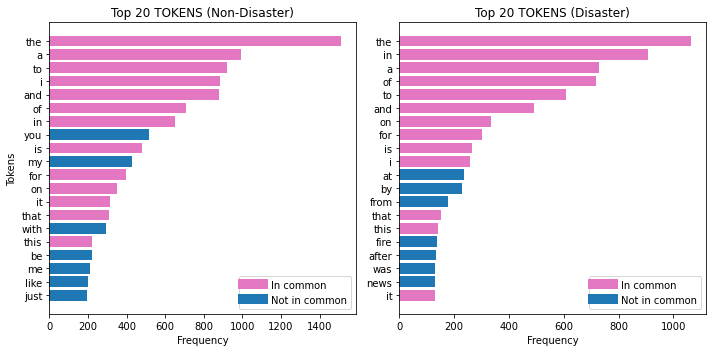

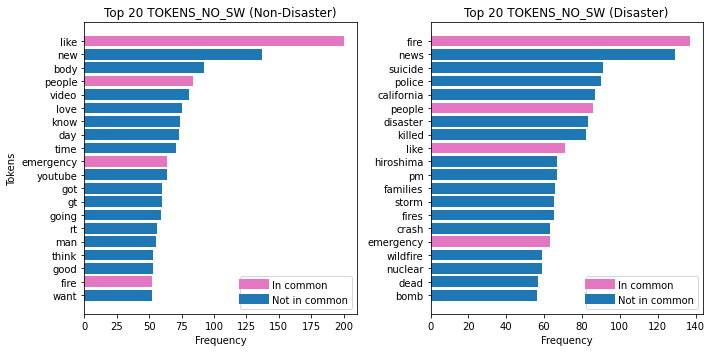

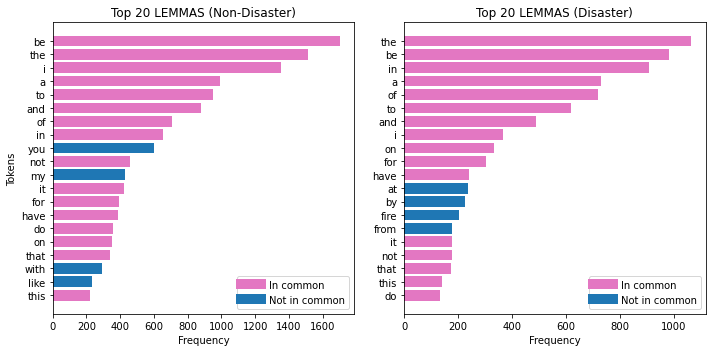

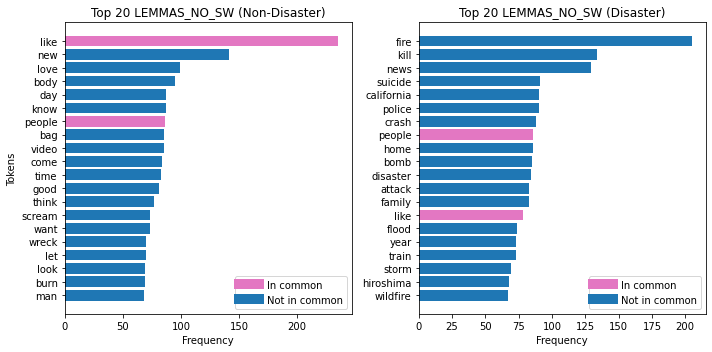

In [51]:
plot_freqdict_classes(X_train['tokens'], y_train)
plot_freqdict_classes(X_train['tokens_no_sw'], y_train)
plot_freqdict_classes(X_train['lemmas'], y_train)
plot_freqdict_classes(X_train['lemmas_no_sw'], y_train)

I can tell from the charts above the version of tweets that are the most different in terms of token frequency is the **lemmatized tweets with no stop words.** In the top 20 tokens from each class, there are only two shared tokens. In contrast, if stop words are not removed, most tokens are shared between classes.

### More linguistic feature engineering

I will use the SpaCy library to extract more linguistic features from the tweets.

### Vectorized part of speech (POS) tags

The SpaCy library is pre-trained to parse through sentences and identify each word's grammatical part of speech.

Here are some examples of what the tool can identify:

In [52]:
# POS VISUALIZATIONS
#
# 
# 
# 
# 
# 
#

In [53]:
secret_sample = X_train['text'].sample(5).apply(lambda x: [s.text for s in nlp(x).sents]).apply(lambda x: [' '.join(tokenizer.tokenize(s)) for s in x]).apply(lambda x: '. '.join(x))
secret_sample

2939                                                              itsdanie noooo. i almost drowned you once tho
3392          this is an evil generation rock and roll evacuation. as far as the eye can see. . hey hey hey hey
6038                                 oilandgas exploration takes seismic shift in gabon to somalia via business
5786                                       leeds fan. rioting in embra at a lower tier league cup final dee dum
4390    ladyfleur the example i used is even worse in that it's a caf trying to market itself hashtag hijacking
Name: text, dtype: object

In [54]:
options_displacy = {'compact':True, 'distance':110, 'bg':'#3056ff', 'color':'fff'}

for tweet in secret_sample:
    displacy.render(nlp(tweet), style='dep', jupyter=True, options=options_displacy)

I plan to use this tool in order to vectorize the detailed [parts of speech](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) of each tweet.

First, I'll convert each token into a string of its POS tag.

In [55]:
# Spacy POS

def spacy_pos(text):
    """
    Takes in a string and returns a list of part of speech tokens.
    """
    sents = [s.text for s in nlp(text).sents]
    sents_tokenized = [tokenizer.tokenize(sent) for sent in sents]
    docs = [nlp(' '.join(tokens)) for tokens in sents_tokenized]
    pos_tokens = [[t.pos_ for t in doc] for doc in docs]
    return list(itertools.chain.from_iterable(pos_tokens))

X_train['text_as_POS'] = X_train['text'].apply(spacy_pos)

In [56]:
X_train.head()

,id,keyword,location,text,tokens,tokens_no_sw,lemmas,lemmas_no_sw,text_as_POS
39,57,ablaze,Paranaque City,ablaze for you lord :d,"[ablaze, for, you, lord]","[ablaze, lord]","[ablaze, for, you, lord]","[ablaze, lord]","[ADJ, ADP, PRON, PROPN]"
418,607,arsonist,heccfidmss@gmail.com,@local_arsonist @diamorfiend the legal system never forgets,"[local, arsonist, diamorfiend, the, legal, system, never, forgets]","[local, arsonist, diamorfiend, legal, system, forgets]","[local, arsonist, diamorfiend, the, legal, system, never, forget]","[local, arsonist, diamorfiend, legal, system, forget]","[ADJ, NOUN, VERB, DET, ADJ, NOUN, ADV, VERB]"
4916,7001,mayhem,"Orlando, FL",i guess ill never be able to go to mayhem...,"[i, guess, ill, never, be, able, to, go, to, mayhem]","[guess, ill, able, mayhem]","[i, guess, ill, never, be, able, to, go, to, mayhem]","[guess, ill, able, mayhem]","[PRON, VERB, ADV, ADV, AUX, ADJ, PART, VERB, ADP, PRON]"
2126,3054,deaths,location_missing,bigamist and his û÷firstûª wife are charged in the deaths of his û÷secondûª pregnant wife her child 8 her mother her nephew 1 and their uû_,"[bigamist, and, his, first, wife, are, charged, in, the, deaths, of, his, second, pregnant, wife, her, child, her, mother, her, nephew, and, their]","[bigamist, wife, charged, deaths, second, pregnant, wife, child, mother, nephew]","[bigamist, and, his, first, wife, be, charge, in, the, death, of, his, second, pregnant, wife, her, child, her, mother, her, nephew, and, their]","[bigamist, wife, charge, death, second, pregnant, wife, child, mother, nephew]","[NOUN, CCONJ, PRON, ADJ, NOUN, AUX, VERB, ADP, DET, NOUN, ADP, PRON, ADJ, ADJ, NOUN, PRON, NOUN, PRON, NOUN, PRON, NOUN, CCONJ, PRON]"
1054,1523,body bags,ANYWEHERE !!,status: last seen buying body bags.,"[status, last, seen, buying, body, bags]","[status, seen, buying, body, bags]","[status, last, see, buy, body, bag]","[status, buy, body, bag]","[NOUN, ADV, VERB, VERB, NOUN, NOUN]"


In order to make the POS vectors, I'm using scikit-learn's CountVectorizer in a slightly unorthodox way. I'm using it to count POS tags rather than tokens.

In [57]:
# Making dataframes of vectorized POS tags

pos_vectorizer = CountVectorizer(tokenizer=spacy_pos)
pos_vec_train = pos_vectorizer.fit_transform(X_train['text'])
pos_vec_df_train = pd.DataFrame(
        pos_vec_train.toarray(),
        columns=pos_vectorizer.get_feature_names_out(),
        index=X_train.index
)

In [58]:
pos_vec_df_train.head()

,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,VERB,X
39,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
418,2,0,1,0,0,1,0,2,0,0,0,0,0,0,2,0
4916,1,1,2,1,0,0,0,0,0,1,2,0,0,0,2,0
2126,3,2,0,1,2,1,0,7,0,0,6,0,0,0,1,0
1054,0,0,1,0,0,0,0,3,0,0,0,0,0,0,2,0


This matrix of parts-of speech will hopefully be useful to the model, but I can take it even further. I'm going to look at disparities in the proportions of POS tags between each class.

In [59]:
pos_vec_df_norm_train = pos_vec_df_train.div(pos_vec_df_train.sum(axis=1), axis=0)
pos_vec_df_norm_train.columns = pos_vec_df_train.columns + '_norm'
pos_vec_df_norm_train.head()

,ADJ_norm,ADP_norm,ADV_norm,AUX_norm,CCONJ_norm,DET_norm,INTJ_norm,NOUN_norm,NUM_norm,PART_norm,PRON_norm,PROPN_norm,PUNCT_norm,SCONJ_norm,VERB_norm,X_norm
39,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.25000,0.25,0.0,0.0,0.000000,0.0
418,0.250000,0.000000,0.125000,0.000000,0.000000,0.125000,0.0,0.250000,0.0,0.0,0.00000,0.00,0.0,0.0,0.250000,0.0
4916,0.100000,0.100000,0.200000,0.100000,0.000000,0.000000,0.0,0.000000,0.0,0.1,0.20000,0.00,0.0,0.0,0.200000,0.0
2126,0.130435,0.086957,0.000000,0.043478,0.086957,0.043478,0.0,0.304348,0.0,0.0,0.26087,0.00,0.0,0.0,0.043478,0.0
1054,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.0,0.500000,0.0,0.0,0.00000,0.00,0.0,0.0,0.333333,0.0


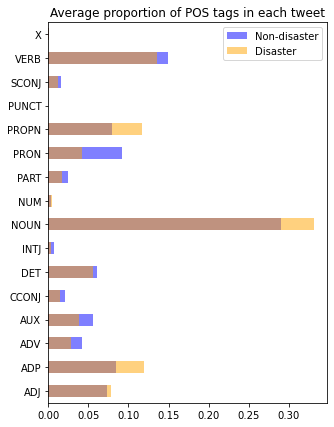

In [60]:
fig, ax = plt.subplots(figsize=(5,7))

pos_plot_0 = pos_vec_df_norm_train[y_train==0].mean().plot(
    kind='barh',
    ax=ax,
    color='blue', alpha=0.5,
    label='Non-disaster'
)
pos_plot_1 = pos_vec_df_norm_train[y_train==1].mean().plot(
    kind='barh',
    ax=ax,
    color='orange', alpha=0.5,
    label='Disaster'
)
ax.set_title('Average proportion of POS tags in each tweet')
ax.set_yticklabels(pos_vec_df_train.columns)
ax.legend()
plt.show()

Between the two classes, there are noticeable disparities with the following POS tags:

* ADP: adposition
* ADV: adverb
* AUX: auxiliary
* NOUN: Noun
* PRON: Pronoun
* PROPN: Proper noun

In [61]:
interesting_tags = ['ADP_norm', 'ADV_norm', 'AUX_norm', 'NOUN_norm', 'PRON_norm', 'PROPN_norm']

pos_vec_df_train = pos_vec_df_train.join(pos_vec_df_norm_train[interesting_tags])

In [62]:
pos_vec_df_train.head()

,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,...,PUNCT,SCONJ,VERB,X,ADP_norm,ADV_norm,AUX_norm,NOUN_norm,PRON_norm,PROPN_norm
39,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.250000,0.000000,0.000000,0.000000,0.25000,0.25
418,2,0,1,0,0,1,0,2,0,0,...,0,0,2,0,0.000000,0.125000,0.000000,0.250000,0.00000,0.00
4916,1,1,2,1,0,0,0,0,0,1,...,0,0,2,0,0.100000,0.200000,0.100000,0.000000,0.20000,0.00
2126,3,2,0,1,2,1,0,7,0,0,...,0,0,1,0,0.086957,0.000000,0.043478,0.304348,0.26087,0.00
1054,0,0,1,0,0,0,0,3,0,0,...,0,0,2,0,0.000000,0.166667,0.000000,0.500000,0.00000,0.00


In [63]:
# MAKE THIS A SEPARATE DF OR TACK ONTO META?
# CHANGE ORDER OF META AND LINGUISTIC?
#
# 
# 
# 
# 
# 
#


In [64]:
# VISUALIZE?
# PROPORTIONS?
#
# 
# 
# 
# 
# 
# #

### Vectorized named-entity recognition (NER) tags 
SpaCy has the capability of recognizing "named-entities" such as places, companies, dates, people, and more. Here are some examples of what the tool can identify.

In [65]:
# VISUALIZE NER EXAMPLES
#
# 
# 
#

For the purposes of identifying disaster tweets, here are the [NER tags](https://towardsdatascience.com/explorations-in-named-entity-recognition-and-was-eleanor-roosevelt-right-671271117218) I am interested in:

* **GPE**: Countries, cities, states.
* **LOC**: Non-GPE locations, mountain ranges, bodies of water.
* **NORP**: Nationalities or religious or political groups.
* **ORG**: Companies, agencies, institutions, etc.

I am again using scikit-learn's CountVectorizer to count the entities that SpaCy finds in each tweet.

In [66]:
# Spacy NER

def spacy_ner(
    text, 
    ner_tags=['GPE', 'NORP', 'ORG', 'LOC']
    ):
    """
    Takes in a string and returns a list of named-entity recognition tags.
    Also takes in a specific list of NER tags to look for.
    To look for all NER tags supported by SpaCy, set `ner_tags=None`.
    Intended use is to use this function as a tokenizer in an sklearn vectorizor.
    """
    tokens = tokenizer.tokenize(text)
    doc = nlp(' '.join(tokens))
    ents = doc.ents
    if ner_tags:
        tags = [ent.label_ for ent in ents if ent.label_ in ner_tags]
        return tags
    else:
        tags = [ent.label_ for ent in ents]
        return tags

In [67]:
# Making dataframes of vectorized NER tags

ner_vectorizer = CountVectorizer(tokenizer=spacy_ner)
ner_vec_train = ner_vectorizer.fit_transform(X_train['text'])
ner_vec_df_train = pd.DataFrame(
        ner_vec_train.toarray(),
        columns=ner_vectorizer.get_feature_names_out(),
        index=X_train.index
)

In [68]:
ner_vec_df_train.head()

,GPE,LOC,NORP,ORG
39,0,0,0,0
418,0,0,0,0
4916,0,0,0,0
2126,0,0,0,0
1054,0,0,0,0


### Using NER to encode the `location` column

As noted earlier, the `location` column contains a lot of user-generated nonsense.

In [69]:
print('Sample of some of the location values')
df['location'].unique()[7:17].tolist()

Sample of some of the location values


['World Wide!!',
 'Paranaque City',
 'milky way',
 'GREENSBORO,NORTH CAROLINA',
 'England.',
 'Sheffield Township, Ohio',
 'India',
 'Barbados',
 'Anaheim',
 'Abuja']

But some of its data may be genuine. I can use named-entity recognition to discern if an entry is referring to an actual location. 

In [70]:
# Find any NER tags in the location column

location_NER_train = X_train['location'].apply(lambda x: [ent.label_ for ent in nlp(x).ents])
location_NER_train.head()

39           [GPE]
418             []
4916    [GPE, ORG]
2126            []
1054         [ORG]
Name: location, dtype: object

In [71]:
# Binarize based on if the location returns a GPE tag (countries, cities, states)
# Add this new feature to the NER training set 

ner_vec_df_train['location_GPE'] = location_NER_train.apply(lambda x: int('GPE' in x))
ner_vec_df_train.head()

,GPE,LOC,NORP,ORG,location_GPE
39,0,0,0,0,1
418,0,0,0,0,0
4916,0,0,0,0,1
2126,0,0,0,0,0
1054,0,0,0,0,0


## Meta-feature Engineering

To engineer more features, I'm going to use seemingly arbitrary information from each tweet. Here's the set of meta-features I plan to make:

* Has URL (binary)
* Character count
* Number of stop words
* Character count of non-stop-words / total character count
* Average length of tokens
* Number of tokens
* Number of unique tokens
* Proportion of stop words
* Proportion of words that are hashtags (#)
* Proportion of words that are mentions (@)

I drew inspiration for some of these features from [this Kaggle entry](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/notebook).

With the meta-features that are token-oriented, I have options. I have four different versions of tokenized tweets:

* tokens
* tokens without stop words
* lemmas
* lemmas without stop words

In order to pick the version of tokens that will likely be most informative to the model, I will run statistical t-tests on each of them. I'm trying to answer the question: **Which version of tokens, when used to engineer a new feature, has the biggest disparity between classes?**

#### Average length of token
Based on the results of the t-tests below, `lemmas` is the best column to use to engineer this feature. It has the largest t-statistic when the two classes are compared.

In [72]:

for column in ['tokens','tokens_no_sw', 'lemmas', 'lemmas_no_sw']:

    tokens = X_train[column][X_train[column].apply(lambda x: x != [])]

    average_length_0 = \
        tokens[y_train==0].apply(lambda x: np.mean([len(t) for t in x]))
    average_length_1 = \
        tokens[y_train==1].apply(lambda x: np.mean([len(t) for t in x]))

    t_test = ttest_ind(average_length_0, average_length_1)
    print(f'{column:{20}}{t_test}')

tokens              Ttest_indResult(statistic=-12.25485499587192, pvalue=4.071918851161369e-34)
tokens_no_sw        Ttest_indResult(statistic=-7.414338752249794, pvalue=1.3932338613216156e-13)
lemmas              Ttest_indResult(statistic=-12.548425599826194, pvalue=1.1445253471131259e-35)
lemmas_no_sw        Ttest_indResult(statistic=-5.931890412967066, pvalue=3.163313982599385e-09)


#### Number of tokens
`lemmas_no_sw` is the best column to use to engineer this feature.

In [73]:
for column in ['tokens','tokens_no_sw', 'lemmas', 'lemmas_no_sw']:

    n_tokens_0 = \
        X_train[column][y_train==0].apply(len)
    n_tokens_1 = \
        X_train[column][y_train==1].apply(len)
        
    t_test = ttest_ind(n_tokens_0, n_tokens_1)
    print(f'{column:{20}}{t_test}')

tokens              Ttest_indResult(statistic=-0.3918892836556608, pvalue=0.6951540682286537)
tokens_no_sw        Ttest_indResult(statistic=-11.725310573680394, pvalue=2.0921522845489343e-31)
lemmas              Ttest_indResult(statistic=0.5769562625397677, pvalue=0.5639908476104489)
lemmas_no_sw        Ttest_indResult(statistic=-12.593670193429448, pvalue=6.55395805950803e-36)


#### Number of unique tokens
`lemmas_no_sw` is the best column to use to engineer this feature.

In [74]:
for column in ['tokens','tokens_no_sw', 'lemmas', 'lemmas_no_sw']:

    unique_tokens_0 = \
        X_train[column][y_train==0].apply(lambda x: len(set(x)))
    unique_tokens_1 = \
        X_train[column][y_train==1].apply(lambda x: len(set(x)))
        
    t_test = ttest_ind(unique_tokens_0, unique_tokens_1)
    print(f'{column:{20}}{t_test}')

tokens              Ttest_indResult(statistic=-0.8675284109441833, pvalue=0.3856875668968016)
tokens_no_sw        Ttest_indResult(statistic=-11.41294672439267, pvalue=7.358243193731784e-30)
lemmas              Ttest_indResult(statistic=-0.47087000571440935, pvalue=0.6377508445846503)
lemmas_no_sw        Ttest_indResult(statistic=-12.202196149352261, pvalue=7.66296758091312e-34)


Now I will make a new DataFrame composed of the meta-features I listed above.

In [75]:
# has_url_Series already exists
# Start a DF with it

meta_features_df_train = pd.DataFrame(has_url_Series_train)

# Character count. Original tweet. No URL.
meta_features_df_train['character_count'] = \
    X_train['text'].apply(len)

# Stop word count. Original tweet. No URL.
meta_features_df_train['sw_count'] = \
    X_train['tokens'].apply(lambda x: len([w for w in x if w in stopword_list]))

# Character count of non-stop-words / original character count. No URL.
meta_features_df_train['non_sw_char_proportion'] = \
    X_train['tokens_no_sw'].apply(lambda x: len(''.join(x))) / X_train['text'].apply(len)

# Average lemma length. Including stop words.
meta_features_df_train['mean_lemma_length'] = \
    X_train['lemmas'].apply(lambda x: np.mean([len(l) for l in x]))

# Lemma count. No stop words.
meta_features_df_train['lemma_count_no_sw'] = \
    X_train['lemmas_no_sw'].apply(len)

# Number of unique lemmas. No stop words.
meta_features_df_train['unique_lemmas_no_sw'] = \
    X_train['lemmas_no_sw'].apply(lambda x: len(set(x)))

# Proportion of stop words
meta_features_df_train['sw_proportion'] = \
    X_train['tokens'].apply(lambda x: len([w for w in x if w in stopword_list]))\
        / X_train['tokens'].apply(len)

# Proportion of hashtags
meta_features_df_train['hashtag_proportion'] = \
    X_train['text'].apply(lambda x: len(re.findall(r'#{1}\w+', x)))\
        / X_train['tokens'].apply(len)

# Proportion of mentions
meta_features_df_train['mention_proportion'] = \
    X_train['text'].apply(lambda x: len(re.findall(r'@{1}\w+', x)))\
        / X_train['tokens'].apply(len)

meta_features_df_train.head()

,has_url,character_count,sw_count,non_sw_char_proportion,mean_lemma_length,lemma_count_no_sw,unique_lemmas_no_sw,sw_proportion,hashtag_proportion,mention_proportion
39,0,22,2,0.454545,4.000000,2,2,0.500000,0.0,0.00
418,0,59,2,0.711864,6.125000,6,6,0.250000,0.0,0.25
4916,0,44,6,0.409091,3.200000,4,4,0.600000,0.0,0.00
2126,0,144,13,0.416667,4.260870,10,9,0.565217,0.0,0.00
1054,0,35,1,0.685714,3.833333,4,4,0.166667,0.0,0.00


In [76]:
# VISUALIZING
#
# 
# 
# 
# 
# 
# 
#

In [77]:
color_non = '#2c2fbf'
color_disaster ='#f14848'
kwargs_histplot = {'kde':True, 'stat':"density", 'linewidth':0, 'bins':'auto'}

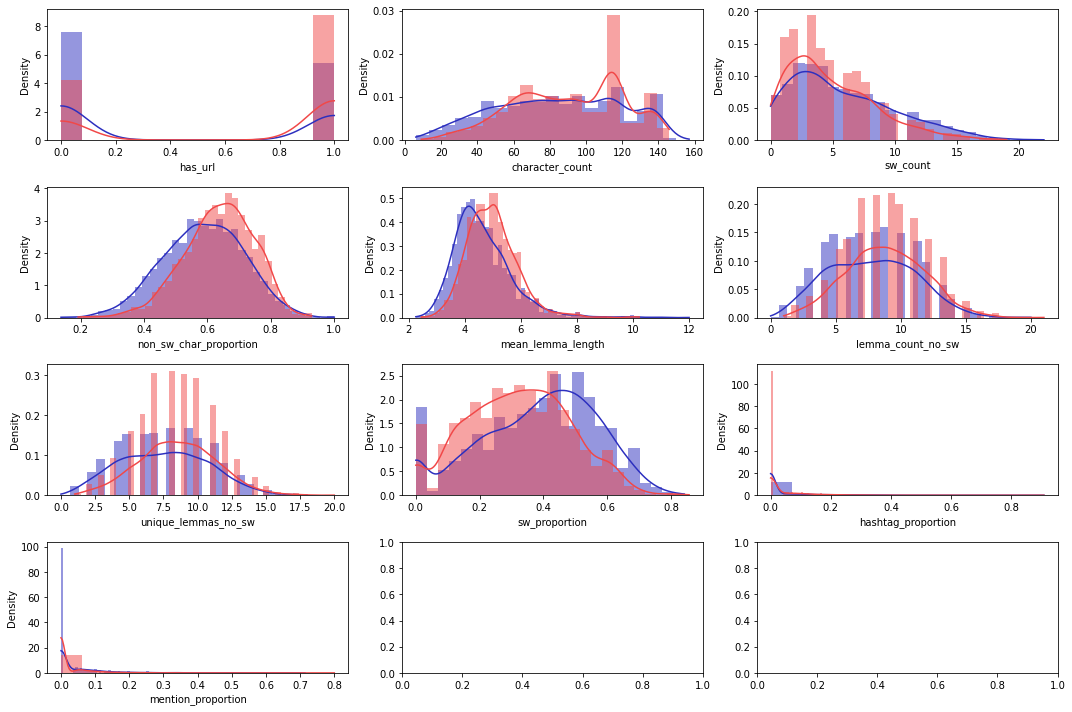

In [78]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,10))
fl_ax = axes.flatten()

for idx, ftr in list(enumerate(meta_features_df_train.columns)):
    sns.histplot(meta_features_df_train[ftr][y_train==0], ax=fl_ax[idx], **kwargs_histplot, color=color_non)
    sns.histplot(meta_features_df_train[ftr][y_train==1], ax=fl_ax[idx], **kwargs_histplot, color=color_disaster)

plt.tight_layout()
plt.show()

# sns.countplot(meta_features_df_train['has_url'][y_train==0], ax=fl_ax[0], color=color_non)
# sns.countplot(meta_features_df_train['has_url'][y_train==1], ax=fl_ax[0], color=color_disaster)

In [79]:
# END VISUALIZING
#
#
# 
# 
# 
# 
# 
#  #

## Vectorizing the tweets

I've engineered linguistic features and meta-features. I'm going to make the actual text of the tweets interpretable by a machine learning model. I'm using scikit-learn's TF-IDF vectorizer and the lemmatized tokens of the tweets.

This vectorizor returns ______________. 

In the same step, I'm going to combine the vectors with the other features I've engineered so far into a single DataFrame. **This is the DataFrame that the model will train on.**

In [80]:
tfidf = TfidfVectorizer(
    tokenizer=spacy_lemmatize, 
    stop_words=stopword_list_lem,
    max_features=500,
    # binary=True
    )
X_train_vec = tfidf.fit_transform(X_train['text'])
X_train_vec_df = pd.DataFrame(
    X_train_vec.toarray(), columns=tfidf.get_feature_names_out(), index=X_train.index
    )

X_train_combined_df = pd.concat(
    [
        X_train_vec_df,
        ohe_keyword_train_df, 
        pos_vec_df_train, 
        ner_vec_df_train, 
        meta_features_df_train,
    ],
    axis=1
    )

# Scaling all features

scaler = StandardScaler()
X_train_combined_df_scaled = scaler.fit_transform(X_train_combined_df)
X_train_combined_df_scaled = pd.DataFrame(X_train_combined_df_scaled, index=X_train.index, columns=X_train_combined_df.columns)

X_train_combined_df_scaled.head()

,abc,ablaze,accident,actually,affect,ago,air,airplane,airport,ambulance,...,has_url,character_count,sw_count,non_sw_char_proportion,mean_lemma_length,lemma_count_no_sw,unique_lemmas_no_sw,sw_proportion,hashtag_proportion,mention_proportion
39,-0.063712,24.039418,-0.106811,-0.062105,-0.073456,-0.063024,-0.078158,-0.064788,-0.066128,-0.075068,...,-1.056584,-2.000603,-0.860117,-1.251505,-0.779544,-1.913161,-1.935395,0.799326,-0.391792,-0.443234
418,-0.063712,-0.060391,-0.106811,-0.062105,-0.073456,-0.063024,-0.078158,-0.064788,-0.066128,-0.075068,...,-1.056584,-0.862925,-0.860117,0.841910,1.341708,-0.681589,-0.639648,-0.605410,-0.391792,3.116885
4916,-0.063712,-0.060391,-0.106811,-0.062105,-0.073456,-0.063024,-0.078158,-0.064788,-0.066128,-0.075068,...,-1.056584,-1.324146,0.149080,-1.621299,-1.578133,-1.297375,-1.287522,1.361221,-0.391792,-0.443234
2126,-0.063712,-0.060391,-0.106811,-0.062105,-0.073456,-0.063024,-0.078158,-0.064788,-0.066128,-0.075068,...,-1.056584,1.750658,1.915175,-1.559667,-0.519134,0.549983,0.332162,1.165779,-0.391792,-0.443234
1054,-0.063712,-0.060391,-0.106811,-0.062105,-0.073456,-0.063024,-0.078158,-0.064788,-0.066128,-0.075068,...,-1.056584,-1.600878,-1.112416,0.629166,-0.945916,-1.297375,-1.287522,-1.073655,-0.391792,-0.443234


#### Apply all pre-processing steps to test and validation sets.
The function below runs the `test` and `val` sets through the exact same preprocessing steps that the `train` set as undergone.

By default, the function makes use of the exact transformer objected that have been trained on `X_train`, in order to avoid data leakage.

In [82]:
def preprocess_tweets(
    df_to_process,
    trained_ohe=ohe,
    tokenizer=tokenizer,
    stop_words=stopword_list, 
    lemmatizer=spacy_lemmatize,
    stop_words_lem=stopword_list_lem,
    pos_maker=spacy_pos,
    trained_pos_vectorizer=pos_vectorizer,
    trained_ner_vectorizer=ner_vectorizer,
    trained_tfidf=tfidf,
    trained_scaler=scaler,
    return_scaled=True,
    return_cleaned=False
):
    index=df_to_process.index
    tweet_df = df_to_process.copy()

    tweet_df['location'] = tweet_df['location'].fillna('location_missing')
    tweet_df['keyword'] = tweet_df['keyword'].fillna('keyword_missing')
    ohe_keyword = trained_ohe.transform(tweet_df[['keyword']])
    keyword_columns = trained_ohe.get_feature_names_out()
    ohe_keyword_df = pd.DataFrame(ohe_keyword, index=index, columns=keyword_columns)

    tweet_df['text'] = tweet_df['text'].apply(lambda x: x.lower())
    has_url_Series = tweet_df['text'].apply(binary_url).rename('has_url')
    tweet_df['has_url'] = has_url_Series
    tweet_df['text'] = \
        tweet_df['text'].apply(lambda x: re.sub(pattern=r'http\S+', repl='', string=x))

    tweet_df['text'] = tweet_df['text'].apply(lambda x: re.sub("&amp;", "and", x))
    tweet_df['tokens'] = tweet_df['text'].apply(tokenizer.tokenize)
    tweet_df['tokens_no_sw'] = \
        tweet_df['tokens'].apply(lambda x: [w for w in x if not w in stop_words])

    tweet_df['lemmas'] = tweet_df['text'].apply(lemmatizer)
    tweet_df['lemmas_no_sw'] = \
        tweet_df['lemmas'].apply(lambda x: [l for l in x if l not in stop_words_lem])

    tweet_df['text_as_pos'] = tweet_df['text'].apply(pos_maker)
    pos_vec = trained_pos_vectorizer.transform(tweet_df['text'])
    pos_vec_df = pd.DataFrame(
        pos_vec.toarray(), 
        columns=trained_pos_vectorizer.get_feature_names_out(),
        index=index
    )
    pos_vec_df_norm = pos_vec_df.div(pos_vec_df.sum(axis=1), axis=0)
    pos_vec_df_norm.columns = pos_vec_df.columns + '_norm'
    interesting_tags = ['ADP_norm', 'ADV_norm', 'AUX_norm', 'NOUN_norm', 'PRON_norm', 'PROPN_norm']
    pos_vec_df = pos_vec_df.join(pos_vec_df_norm[interesting_tags])

    ner_vec = trained_ner_vectorizer.transform(tweet_df['text'])
    ner_vec_df = pd.DataFrame(
        ner_vec.toarray(),
        columns=trained_ner_vectorizer.get_feature_names_out(),
        index=index
    )
    ner_vec_df['location_GPE'] = tweet_df['location'].apply(lambda x: int('GPE' in [ent.label_ for ent in nlp(x).ents]))

    meta_features_df = pd.DataFrame(has_url_Series)
    # Character count. Original tweet. No URL.
    meta_features_df['character_count'] = \
        tweet_df['text'].apply(len)
    # Stop word count. Original tweet. No URL.
    meta_features_df['sw_count'] = \
        tweet_df['tokens'].apply(lambda x: len([w for w in x if w in stop_words]))
    # Character count of non-stop-words / original character count. No URL.
    meta_features_df['non_sw_char_proportion'] = \
        tweet_df['tokens_no_sw'].apply(lambda x: len(''.join(x))) / tweet_df['text'].apply(len)
    # Average lemma length. Including stop words.
    meta_features_df['mean_lemma_length'] = \
        tweet_df['lemmas'].apply(lambda x: np.mean([len(l) for l in x]))
    # Lemma count. No stop words.
    meta_features_df['lemma_count_no_sw'] = \
        tweet_df['lemmas_no_sw'].apply(len)
    # Number of unique lemmas. No stop words.
    meta_features_df['unique_lemmas_no_sw'] = \
        tweet_df['lemmas_no_sw'].apply(lambda x: len(set(x)))
    # Proportion of stop words
    meta_features_df['sw_proportion'] = \
        tweet_df['tokens'].apply(lambda x: len([w for w in x if w in stop_words]))\
            / tweet_df['tokens'].apply(len)\
    # Proportion of hashtags
    meta_features_df['hashtag_proportion'] = \
        tweet_df['text'].apply(lambda x: len(re.findall(r'#{1}\w+', x)))\
            / tweet_df['tokens'].apply(len)
    # Proportion of mentions
    meta_features_df['mention_proportion'] = \
        tweet_df['text'].apply(lambda x: len(re.findall(r'@{1}\w+', x)))\
            / tweet_df['tokens'].apply(len)

    tweets_vec = trained_tfidf.transform(tweet_df['text'])
    tweets_vec_df = pd.DataFrame(
        tweets_vec.toarray(), columns=trained_tfidf.get_feature_names_out(), index=index
    )
    tweets_combined_df = pd.concat(
        [
            tweets_vec_df,
            ohe_keyword_df,
            pos_vec_df,
            ner_vec_df,
            meta_features_df
        ],
        axis=1
    )
    tweets_combined_df_scaled = trained_scaler.transform(tweets_combined_df)
    tweets_combined_df_scaled = pd.DataFrame(tweets_combined_df_scaled, index=index, columns=tweets_combined_df.columns)

    if return_scaled:
        if return_cleaned:
            return {'processed':tweets_combined_df_scaled, 'cleaned':tweet_df}
        else:
            return tweets_combined_df_scaled
    else:
        if return_cleaned:
            return {'processed':tweets_combined_df, 'cleaned':tweet_df}
        else:
            return tweets_combined_df

In [83]:
X_test_combined_df_scaled = preprocess_tweets(X_test)
X_val_combined_df_scaled = preprocess_tweets(X_val)

In [84]:
###########################################################
###########################################################

In [85]:
# Visualizing NN

def plot_nn_curves(model_history):

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,12))
    fl_ax = axes.flatten()
    for idx, metric in enumerate(['loss', 'accuracy', 'precision', 'recall', 'auc', 'f1']):
        pair = [m for m in model_history.history.keys() if metric in m]
        fl_ax[idx].plot(model_history.history[pair[0]], label=metric)
        fl_ax[idx].plot(model_history.history[pair[1]], label=metric+'_val')
        fl_ax[idx].set_xlabel('epochs')
        fl_ax[idx].set_ylabel(metric)
        fl_ax[idx].set_title(f'{metric.upper()} Evaluation')
        fl_ax[idx].legend()
        plt.tight_layout();

In [86]:
X_train_combined_df_scaled.shape[1]

759

In [87]:
n_input = X_train_combined_df_scaled.shape[1]

In [88]:
## Making an f1 scorer for Keras
## https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d#:~:text=By%20default%2C%20f1%20score%20is,like%20accuracy%2C%20categorical%20accuracy%20etc.

import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

precision = Precision()
recall = Recall()
auc = AUC()
f1 = get_f1 ##

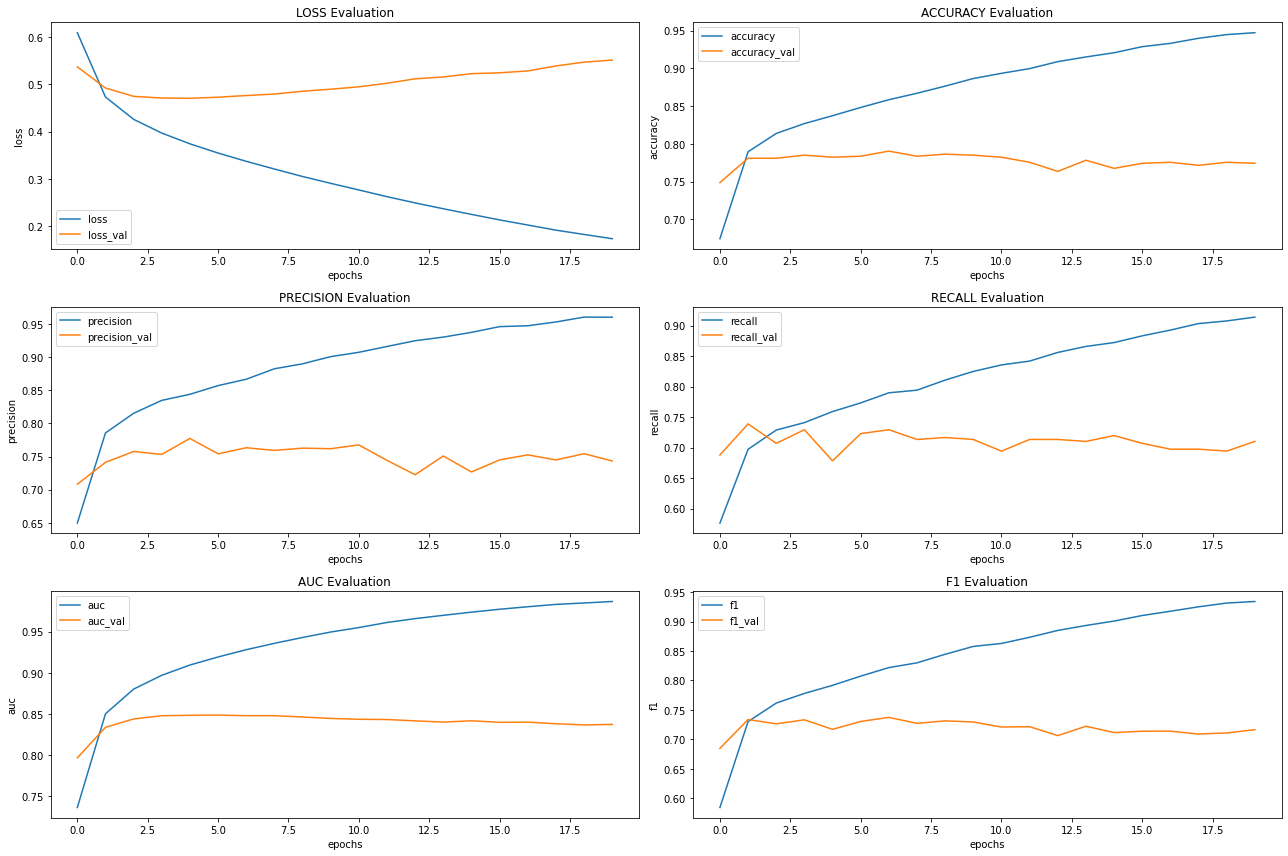

In [204]:
# Baseline

model = models.Sequential()

model.add(layer=layers.Dense(
        units=380,
        activation='relu',
        input_shape=(n_input,)
))

model.add(layer=layers.Dense(
    units=1,
    activation='sigmoid',
))

model.compile(
    optimizer='SGD',
    loss='binary_crossentropy',
    metrics=['accuracy', precision, recall, auc, f1]
)

early_stopping = [
    EarlyStopping(monitor='val_loss', patience=15)
    ]

model_val = model.fit(
    np.array(X_train_combined_df_scaled),
    np.array(y_train),
    epochs=100,
    batch_size=32,
    validation_data=(X_val_combined_df_scaled, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(model_val)

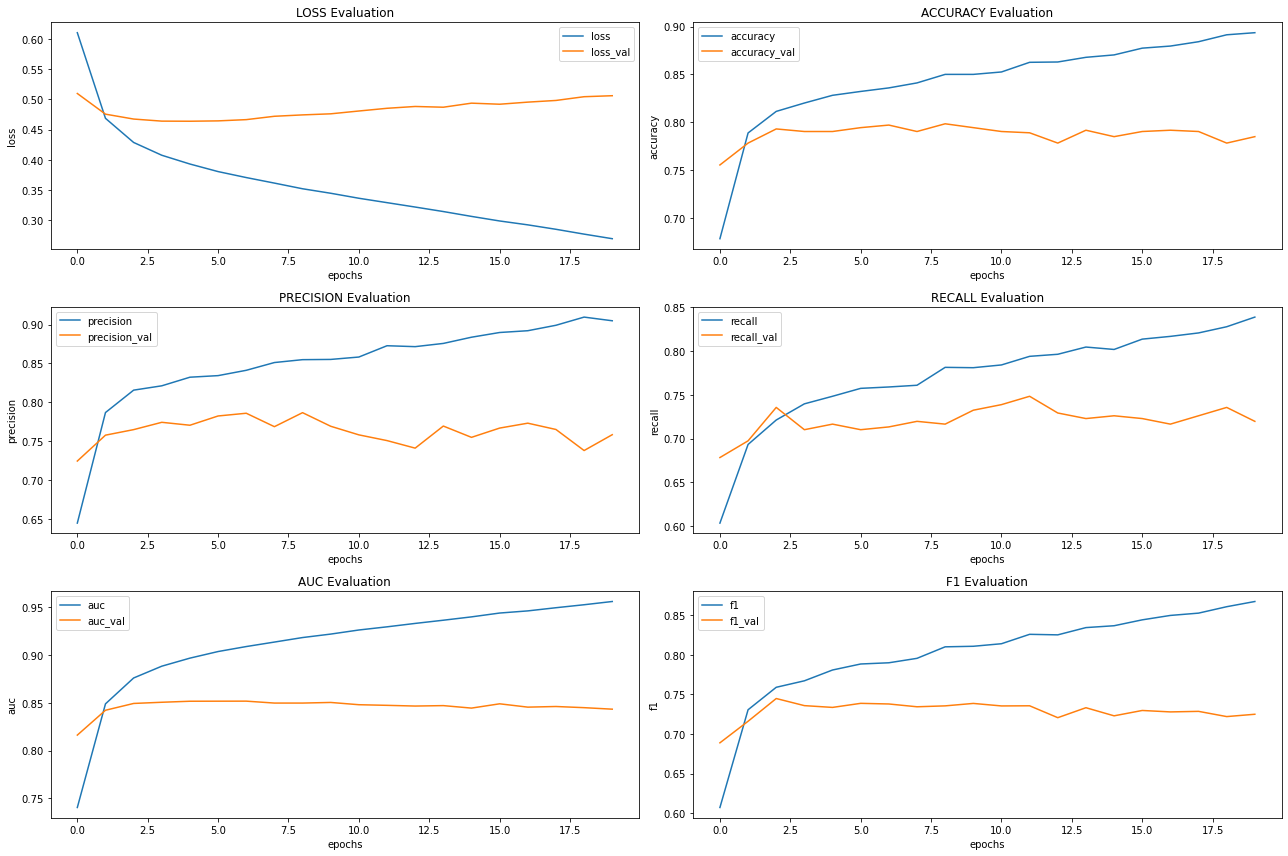

In [205]:
# Leaky ReLU

model = models.Sequential()

model.add(layer=layers.Dense(
        units=380,
        activation=LeakyReLU(),
        input_shape=(n_input,)
))

model.add(layer=layers.Dense(
    units=1,
    activation='sigmoid',
))

model.compile(
    optimizer='SGD',
    loss='binary_crossentropy',
    metrics=['accuracy', precision, recall, auc, f1]
)

early_stopping = [
    EarlyStopping(monitor='val_loss', patience=15)
    ]

model_val = model.fit(
    np.array(X_train_combined_df_scaled),
    np.array(y_train),
    epochs=100,
    batch_size=32,
    validation_data=(X_val_combined_df_scaled, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(model_val)

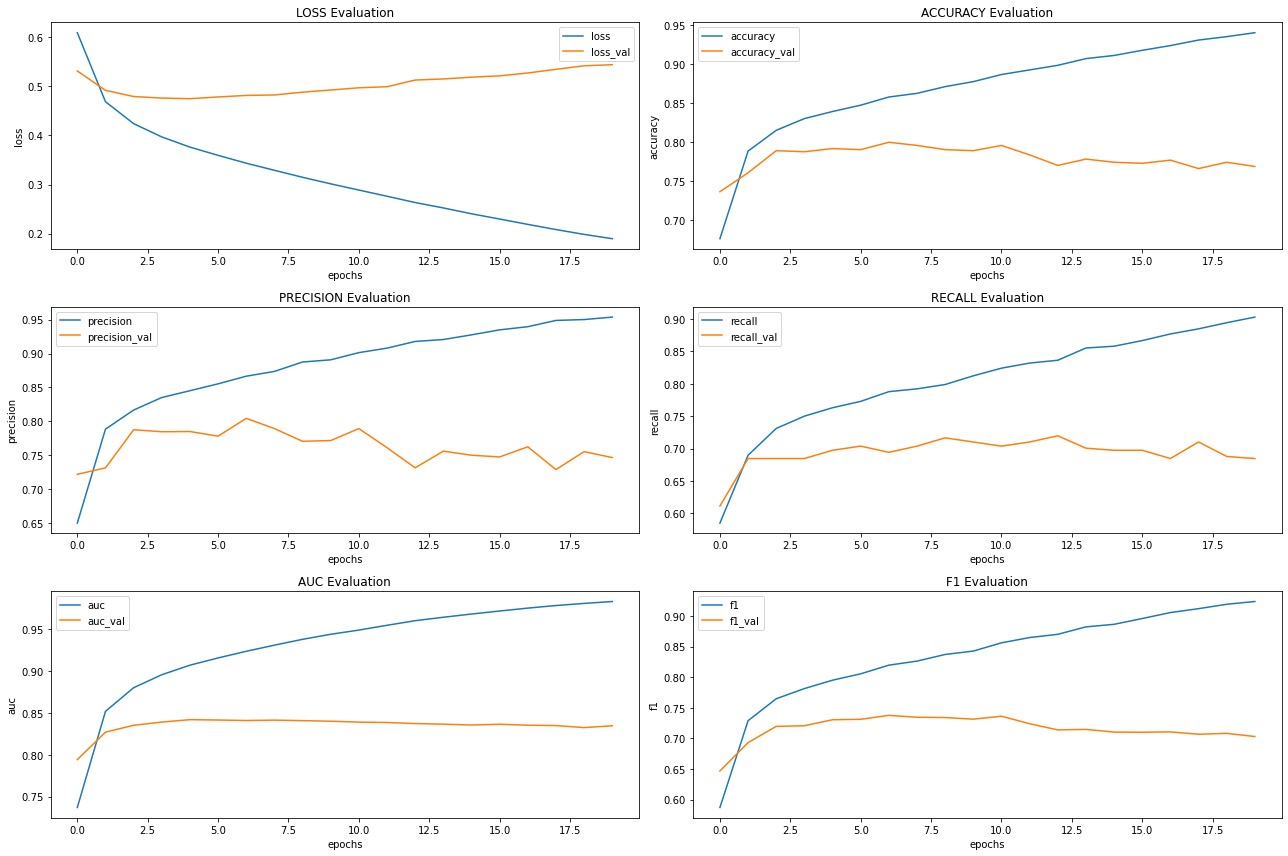

In [206]:
# Tweak Leaky ReLU

model = models.Sequential()

model.add(layer=layers.Dense(
        units=380,
        activation=LeakyReLU(0.05),
        input_shape=(n_input,)
))

model.add(layer=layers.Dense(
    units=1,
    activation='sigmoid',
))

model.compile(
    optimizer='SGD',
    loss='binary_crossentropy',
    metrics=['accuracy', precision, recall, auc, f1]
)

early_stopping = [
    EarlyStopping(monitor='val_loss', patience=15)
    ]

model_val = model.fit(
    np.array(X_train_combined_df_scaled),
    np.array(y_train),
    epochs=100,
    batch_size=32,
    validation_data=(X_val_combined_df_scaled, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(model_val)

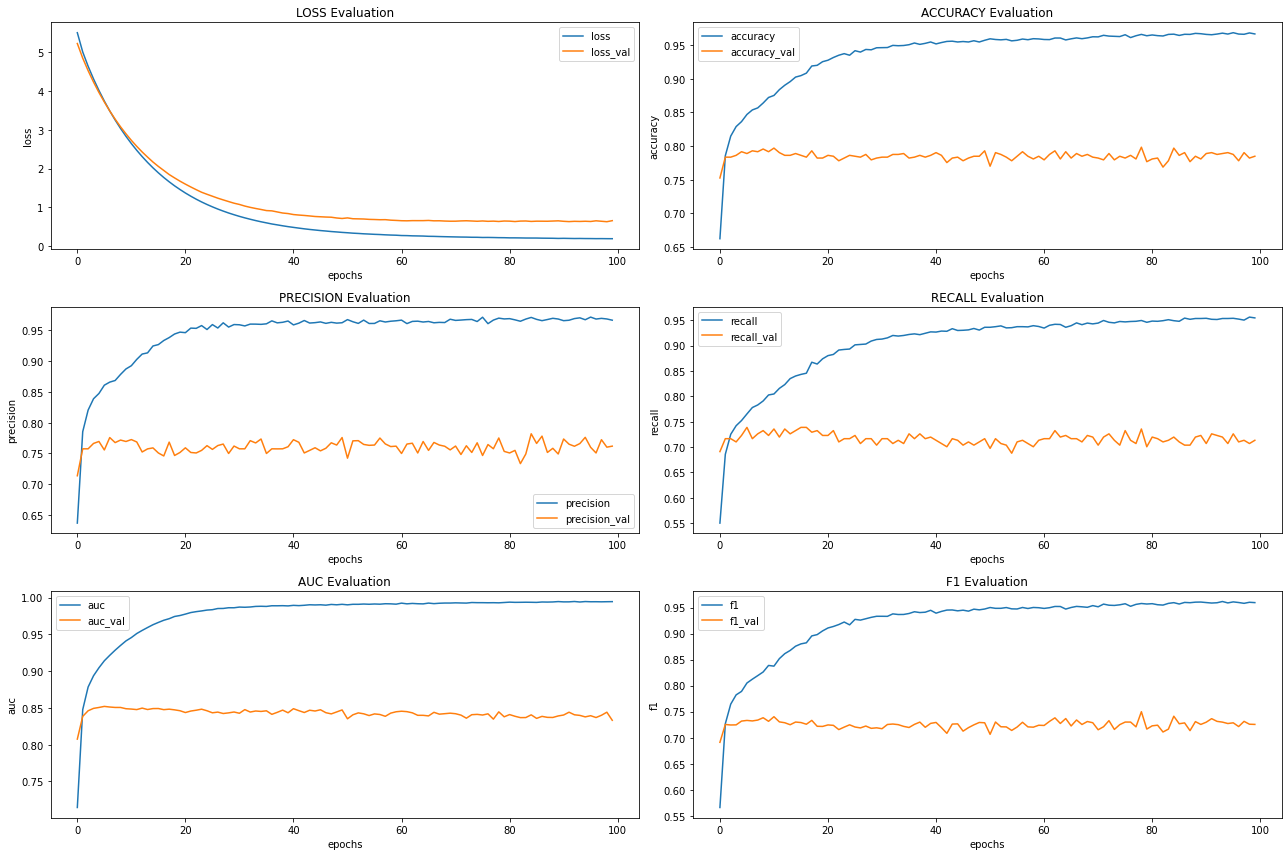

In [207]:
# Add regularization

model = models.Sequential()

model.add(layer=layers.Dense(
        units=380,
        activation=LeakyReLU(0.05),
        input_shape=(n_input,),
        kernel_regularizer=regularizers.L2()
))

model.add(layer=layers.Dense(
    units=1,
    activation='sigmoid',
))

model.compile(
    optimizer='SGD',
    loss='binary_crossentropy',
    metrics=['accuracy', precision, recall, auc, f1]
)

early_stopping = [
    EarlyStopping(monitor='val_loss', patience=15)
    ]

model_val = model.fit(
    np.array(X_train_combined_df_scaled),
    np.array(y_train),
    epochs=100,
    batch_size=32,
    validation_data=(X_val_combined_df_scaled, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(model_val)

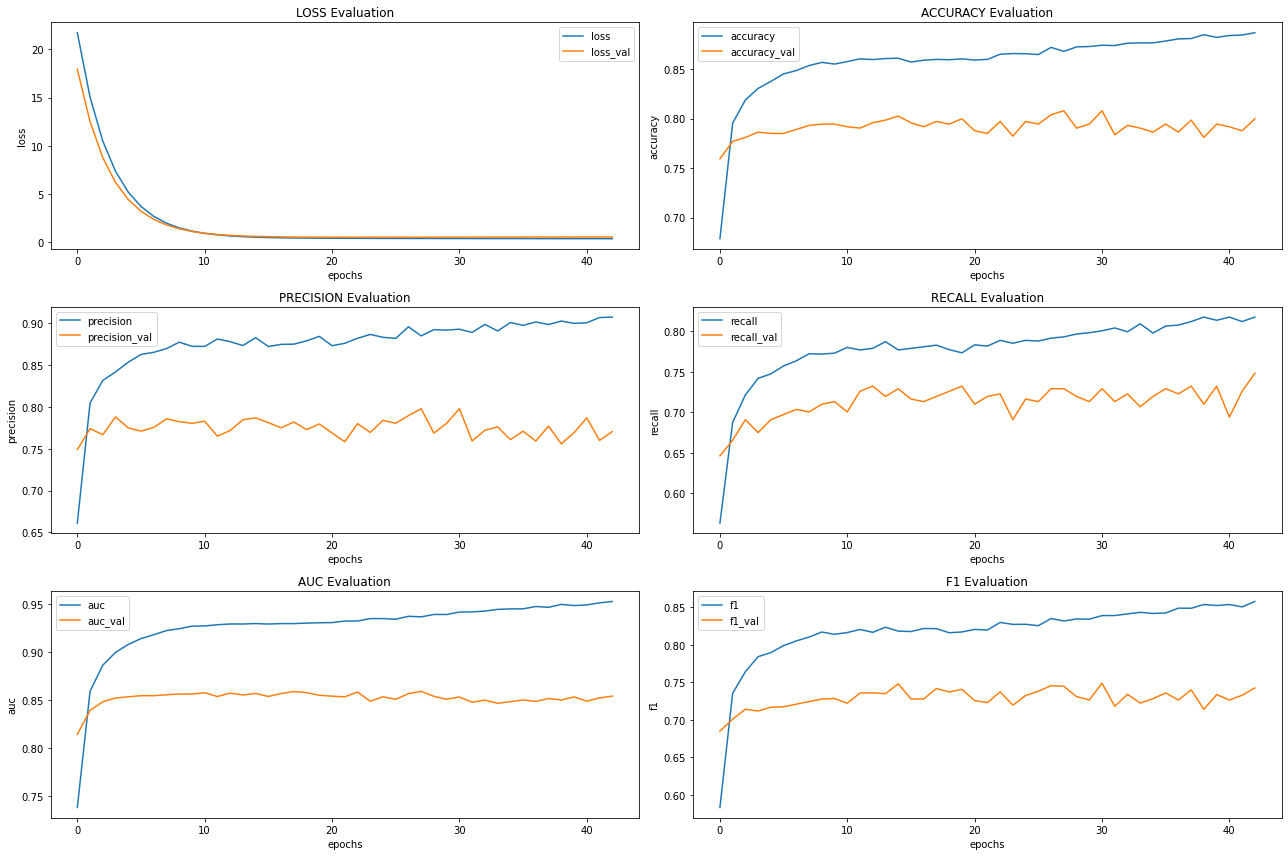

In [208]:
# Tweak regularization

model = models.Sequential()

model.add(layer=layers.Dense(
        units=380,
        activation=LeakyReLU(0.05),
        input_shape=(n_input,),
        kernel_regularizer=regularizers.L2(0.05)
))

model.add(layer=layers.Dense(
    units=1,
    activation='sigmoid',
))

model.compile(
    optimizer='SGD',
    loss='binary_crossentropy',
    metrics=['accuracy', precision, recall, auc, f1]
)

early_stopping = [
    EarlyStopping(monitor='val_loss', patience=15)
    ]

model_val = model.fit(
    np.array(X_train_combined_df_scaled),
    np.array(y_train),
    epochs=100,
    batch_size=32,
    validation_data=(X_val_combined_df_scaled, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(model_val)

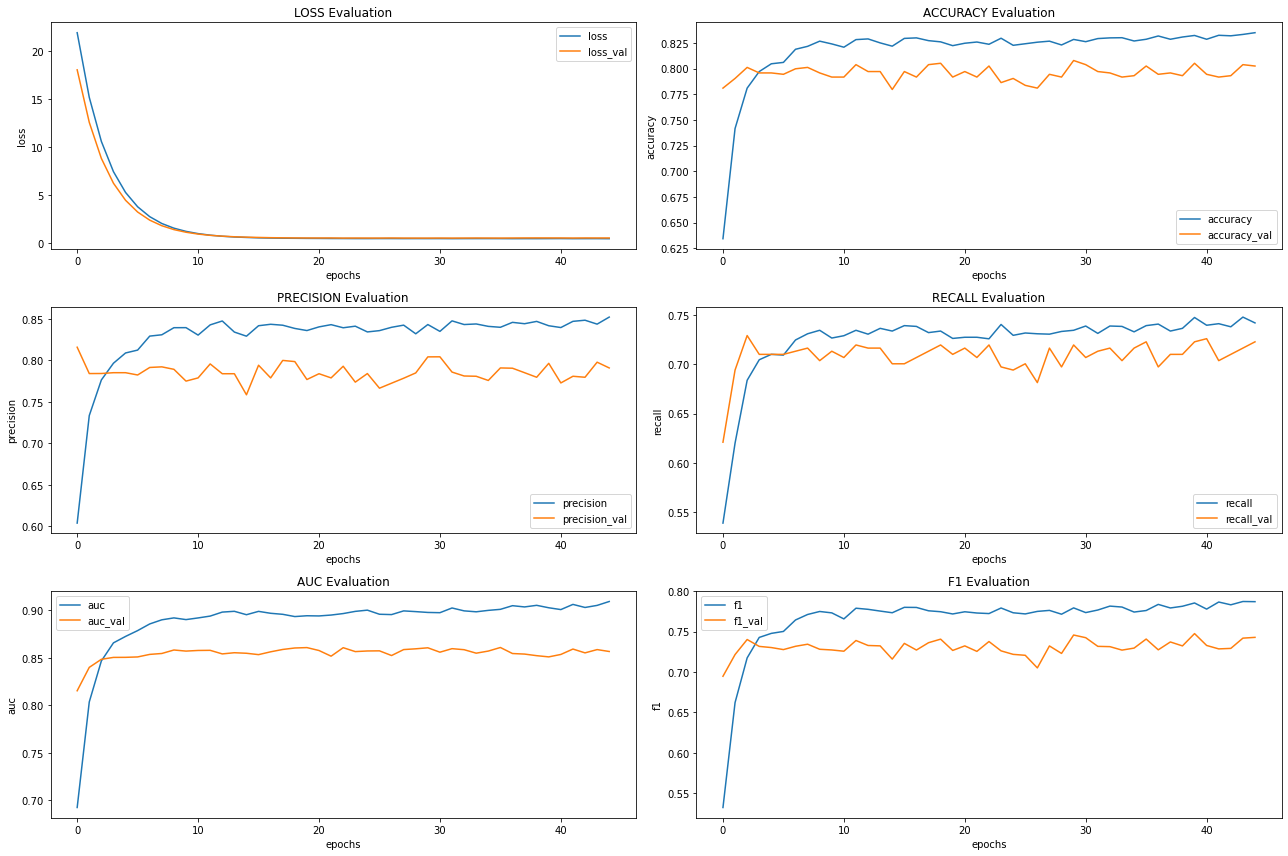

In [209]:
# Add dropout

model = models.Sequential()

model.add(layers.Dropout(0.2, input_shape=(n_input,)))

model.add(layer=layers.Dense(
    units=380,
    activation=LeakyReLU(0.05),
    kernel_regularizer=regularizers.L2(0.05)
))
model.add(layers.Dropout(0.2))

model.add(layer=layers.Dense(
    units=1,
    activation='sigmoid',
))

model.compile(
    optimizer='SGD',
    loss='binary_crossentropy',
    metrics=['accuracy', precision, recall, auc, f1]
)

early_stopping = [
    EarlyStopping(monitor='val_loss', patience=15)
    ]

model_val = model.fit(
    np.array(X_train_combined_df_scaled),
    np.array(y_train),
    epochs=100,
    batch_size=32,
    validation_data=(X_val_combined_df_scaled, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(model_val)

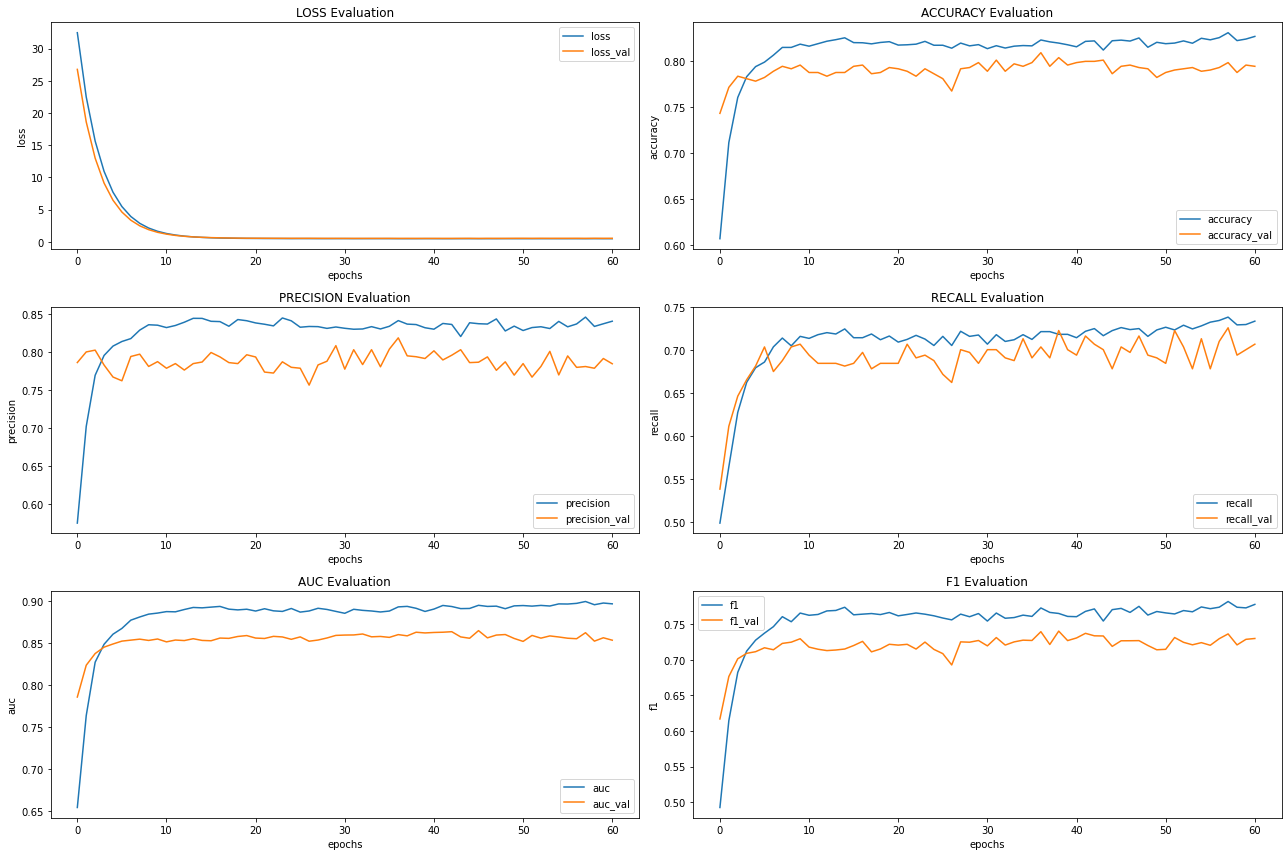

In [210]:
# Add more layers

model = models.Sequential()

model.add(layers.Dropout(0.2, input_shape=(n_input,)))

model.add(layer=layers.Dense(
    units=380,
    activation=LeakyReLU(0.05),
    kernel_regularizer=regularizers.L2(0.05)
))
model.add(layers.Dropout(0.2))

model.add(layer=layers.Dense(
    units=190,
    activation=LeakyReLU(0.05),
    kernel_regularizer=regularizers.L2(0.05)
))
model.add(layers.Dropout(0.2))

model.add(layer=layers.Dense(
    units=1,
    activation='sigmoid',
))

model.compile(
    optimizer='SGD',
    loss='binary_crossentropy',
    metrics=['accuracy', precision, recall, auc, f1]
)

early_stopping = [
    EarlyStopping(monitor='val_loss', patience=15)
    ]

model_val = model.fit(
    np.array(X_train_combined_df_scaled),
    np.array(y_train),
    epochs=100,
    batch_size=32,
    validation_data=(X_val_combined_df_scaled, y_val),
    verbose=False,
    callbacks=early_stopping
)

plot_nn_curves(model_val)

In [ ]:
##############################################
##############################################

In [98]:
from sklearn.metrics import \
    accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

In [99]:
# made_up_tweets = pd.read_csv('./stuff_to_ignore/made_up_tweets.csv')
# made_up_tweets_processed = preprocess_tweets(made_up_tweets)

In [100]:
# probs = pd.Series(model.predict(made_up_tweets_processed).reshape(1,-1)[0]).rename('probs')
# preds = pd.Series(model.predict(made_up_tweets_processed).reshape(1,-1)[0]).apply(lambda x: int(x >= 0.5)).rename('preds')

In [104]:
# recall_score(made_up_tweets['target'], preds)

In [102]:
# print(classification_report(made_up_tweets['target'], preds))

In [103]:
# confusion_matrix(made_up_tweets['target'], preds)

In [105]:
# with_preds = preprocess_tweets(made_up_tweets, return_cleaned=True, return_scaled=False)['cleaned'][['location', 'text', 'target']].join([preds, probs])

In [106]:
# with_preds['outcome'] = (with_preds['preds'] - with_preds['target']).map({-1:'NEGATIVE', 1:'POSITIVE', 0:'true'})

In [107]:
# with_preds

In [113]:
################

In [114]:
rfc = RandomForestClassifier()
rfc.fit(X_train_combined_df_scaled, y_train)
cross_val_score(rfc, X_test_combined_df_scaled, y_test)

array([0.7114094 , 0.72483221, 0.75838926, 0.73648649, 0.72297297])

In [115]:
sorted(list(zip(X_train_combined_df_scaled.columns, rfc.feature_importances_.tolist())), key=lambda x: x[1], reverse=True)

[('non_sw_char_proportion', 0.03368316215096641),
 ('mean_lemma_length', 0.03132515448980581),
 ('character_count', 0.030498762556077474),
 ('ADP_norm', 0.028357174546760462),
 ('NOUN_norm', 0.027896602652692767),
 ('PRON_norm', 0.025701631350888283),
 ('sw_proportion', 0.02329438242364709),
 ('lemma_count_no_sw', 0.020328869357889426),
 ('GPE', 0.018824941755607),
 ('PROPN_norm', 0.01870411643676575),
 ('PRON', 0.018309296608168265),
 ('has_url', 0.017021503411706666),
 ('unique_lemmas_no_sw', 0.016899985955784864),
 ('NOUN', 0.016425538004512442),
 ('sw_count', 0.015432217886813175),
 ('ADP', 0.014934833060645362),
 ('mention_proportion', 0.014922270458676331),
 ('AUX_norm', 0.013271740048874584),
 ('PROPN', 0.012350807790332338),
 ('VERB', 0.011647958806901393),
 ('hashtag_proportion', 0.011032599026516883),
 ('ADV_norm', 0.010622832048411725),
 ('ADJ', 0.009544728835182766),
 ('DET', 0.008965131163121278),
 ('fire', 0.008841581803317613),
 ('AUX', 0.007453656587641044),
 ('location

In [138]:
for col in ohe_keyword_train_df.columns:
    class0=ohe_keyword_train_df[col][y_train==0]
    class1=ohe_keyword_train_df[col][y_train==1]
    t = abs(ttest_ind(class0, class1)[0])
    if t > 3:
        print(f'{col:{30}}{t}')

keyword_aftershock            4.154249338301838
keyword_airplane accident     3.8799717582885545
keyword_armageddon            3.756189884625867
keyword_army                  3.0497492741465355
keyword_avalanche             3.081852127204283
keyword_blaze                 3.46710254214995
keyword_blazing               4.202247079653663
keyword_bleeding              3.1127828275317415
keyword_blew up               3.730311765046634
keyword_blight                3.5190127828703197
keyword_blizzard              4.186312817365817
keyword_blood                 3.263480259147722
keyword_bloody                3.5352864533052957
keyword_body bag              4.332384777882984
keyword_body bags             4.788946032287427
keyword_bombing               4.132564081055192
keyword_bridge collapse       4.73453373516737
keyword_buildings on fire     4.4394945578387635
keyword_casualties            4.144695385836701
keyword_collide               3.5352864533052957
keyword_collision             4.652

In [139]:
# Total time:
t = time.time() - start_time
print(f'Notebook run time: {t//60:.0f} minutes and {t%60:.0f} seconds')

Notebook run time: 40 minutes and 32 seconds


In [ ]:
####################